# **Moive Recommendation**
In this notebook, we use Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

# Set Up Environments

In [1]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [4]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [5]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [6]:
# Import a Spark function from library
from pyspark.sql.functions import col

## Libraries 

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [9]:
movies_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Movies/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Movies/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Movies/links.csv", format='csv', header = True)
tags_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Movies/tags.csv", format='csv', header = True)

In [10]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [11]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [12]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [13]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



# Part 1: Data Exploration 

In [14]:
ratings_df = ratings_df.drop_duplicates(['userId', 'movieId'])

In [15]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [16]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1) 
tmp2 = ratings_df.select('movieId').distinct().count() 
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2)) 

3446 out of 9724 movies are rated by only one user


In [17]:
ratings_df.registerTempTable("ratings")
movies_df.registerTempTable("movies") 
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.3.1-bin-hadoop3/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Q1: The number of Users

In [18]:
q1_result=spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
q1_result.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



### Q2: The number of Movies

In [19]:
q2_result=spark.sql("Select Count(movieId) as Number_of_Moives from movies") 
q2_result.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



### Q3:  How many movies are rated by users? List movies not rated before

In [20]:
q3_result_1 = spark.sql("select count(distinct movieId) as Number_of_Rated_Moives from ratings") 
q3_result_1.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [21]:
# movies that have not been rated before: 50 movies as an example
unrated_list=spark.sql("SELECT * FROM movies WHERE movieId NOT IN (SELECT movieId FROM ratings) LIMIT 50")
print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

### Q4: List Movie Genres 

In [22]:
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [23]:
q4_result=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
q4_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Q5: The number of movies for Each Category 

In [24]:
# size of each category 
q5_result_1=spark.sql("Select genres,Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By 1 Order by 2 DESC")
q5_result_1.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [25]:
# list all movie for each category 
q5_result_2=spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By 1")
q5_result_2.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

# Part2: Spark ALS based approach for training model


In [26]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|   1024|   5.0|964982876|
|     1|   1030|   3.0|964982903|
|     1|   1031|   5.0|964982653|
|     1|   1089|   5.0|964982951|
|     1|    110|   4.0|964982176|
|     1|   1206|   5.0|964983737|
|     1|   1219|   2.0|964983393|
|     1|   1220|   5.0|964981909|
|     1|   1226|   5.0|964983618|
|     1|   1240|   5.0|964983723|
|     1|   1270|   5.0|964983705|
|     1|   1275|   5.0|964982290|
|     1|   1282|   5.0|964982703|
|     1|   1291|   5.0|964981909|
|     1|   1396|   3.0|964983017|
|     1|   1473|   4.0|964980875|
|     1|   1552|   4.0|964982620|
|     1|    157|   5.0|964984100|
|     1|   1573|   5.0|964982290|
+------+-------+------+---------+
only showing top 20 rows



In [27]:
movie_ratings=ratings_df.drop('timestamp')

In [28]:
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [29]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|   1009|   3.0|
|     1|    101|   5.0|
|     1|   1023|   5.0|
|     1|   1024|   5.0|
|     1|   1025|   5.0|
|     1|   1029|   5.0|
|     1|   1030|   3.0|
|     1|   1031|   5.0|
|     1|   1032|   5.0|
|     1|   1042|   4.0|
|     1|   1049|   5.0|
|     1|   1060|   4.0|
|     1|   1073|   5.0|
|     1|   1080|   5.0|
|     1|   1089|   5.0|
|     1|   1090|   4.0|
|     1|   1092|   5.0|
|     1|   1097|   5.0|
|     1|    110|   4.0|
+------+-------+------+
only showing top 20 rows



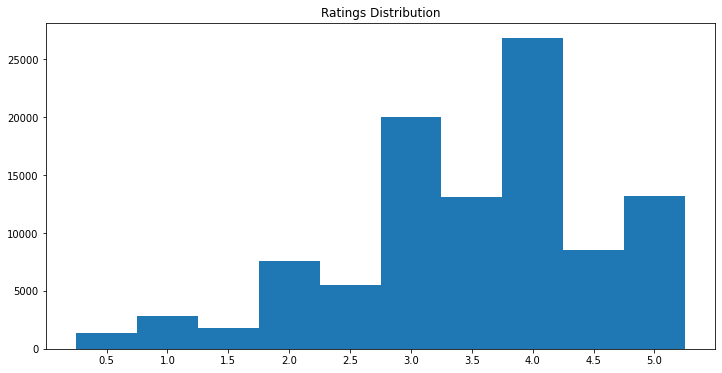

In [30]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas() 
plt.figure(figsize=[12,6])  
plt.bar(x='rating',height='count',data=rating_count,width=0.5) 
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5)) 
plt.show()

In [31]:
rating_count.head()

,rating,count
0,5.0,13211
1,2.5,5550
2,2.0,7551
3,3.0,20047
4,1.5,1791


## ALS Model Selection and Evaluation (Tune hyperparameters)


Tune hyperparameters via hold-out validation or cross-validation by grid search.
The most important hyperparameters: 
1. maxIter: the maximum number of iterations to run (defaults to 10);
2. rank: the number of latent factors in the model (defaults to 10);
3. regParam: the regularization parameter in ALS (defaults to 1.0);
https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html


In [32]:
# Import package
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.recommendation import ALS  
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [33]:
#Create test and train set 
(training,test) = movie_ratings.randomSplit([0.8,0.2]) 

In [34]:
#Create ALS model
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6) 

In [35]:
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation 
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

Check the best parameters

In [36]:
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 25
-> alpha: 0.1


Extract best model from the tuning exercise using ParamGridBuilder.

In [37]:
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.48519850177804


## Model testing
And finally, make a prediction and check the testing error.

In [38]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [39]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.8804295287474494
**Best Model**
 Rank:  25
 MaxIter:  10
 RegParam:  0.1


In [40]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|      3|   4.0|   3.69731|
|     1|     70|   3.0|  3.819016|
|     1|    101|   5.0| 3.7991996|
|     1|    110|   4.0| 4.5887394|
|     1|    316|   3.0| 3.5162554|
|     1|    333|   5.0| 4.2564487|
|     1|    349|   4.0| 3.7588208|
|     1|    527|   5.0| 4.5716906|
|     1|    648|   3.0|  4.177069|
|     1|    780|   3.0|  3.885841|
|     1|    919|   5.0| 4.2108927|
|     1|    943|   4.0|  4.546649|
|     1|   1030|   3.0| 3.1075165|
|     1|   1042|   4.0| 4.0907316|
|     1|   1073|   5.0| 4.5381303|
|     1|   1092|   5.0| 3.8377094|
|     1|   1198|   5.0|  4.660285|
|     1|   1270|   5.0|  4.792702|
|     1|   1377|   3.0|  3.551931|
|     1|   1552|   4.0| 3.4490285|
+------+-------+------+----------+
only showing top 20 rows



## Model apply and see the performance 

In [41]:
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.5833217038566241


In [42]:
alldata.registerTempTable("alldata")

/content/spark-3.3.1-bin-hadoop3/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [43]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|      1|   4.0|  4.298361|
|     1|   1009|   3.0|   2.90958|
|     1|    101|   5.0| 3.7991996|
|     1|   1023|   5.0| 4.8173013|
|     1|   1024|   5.0|  4.654805|
|     1|   1025|   5.0|  4.592202|
|     1|   1029|   5.0| 4.5656595|
|     1|   1030|   3.0| 3.1075165|
|     1|   1031|   5.0| 4.7130055|
|     1|   1032|   5.0| 4.3596745|
|     1|   1042|   4.0| 4.0907316|
|     1|   1049|   5.0|  4.332242|
|     1|   1060|   4.0|  4.230328|
|     1|   1073|   5.0| 4.5381303|
|     1|   1080|   5.0|  4.693545|
|     1|   1089|   5.0| 4.5833077|
|     1|   1090|   4.0| 4.2683077|
|     1|   1092|   5.0| 3.8377094|
|     1|   1097|   5.0|  4.506488|
|     1|    110|   4.0| 4.5887394|
+------+-------+------+----------+
only showing top 20 rows



In [44]:
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|      1|    Toy Story (1995)|Adventure|Animati...|     1|      1|   4.0|  4.298361|
|   1009|Escape to Witch M...|Adventure|Childre...|     1|   1009|   3.0|   2.90958|
|    101|Bottle Rocket (1996)|Adventure|Comedy|...|     1|    101|   5.0| 3.7991996|
|   1023|Winnie the Pooh a...|Animation|Childre...|     1|   1023|   5.0| 4.8173013|
|   1024|Three Caballeros,...|Animation|Childre...|     1|   1024|   5.0|  4.654805|
|   1025|Sword in the Ston...|Animation|Childre...|     1|   1025|   5.0|  4.592202|
|   1029|        Dumbo (1941)|Animation|Childre...|     1|   1029|   5.0| 4.5656595|
|   1030|Pete's Dragon (1977)|Adventure|Animati...|     1|   1030|   3.0| 3.1075165|
|   1031|Bedknobs and Broo...|Adventure|Childre...|     1|   1031

## Recommend moive to users with id: 575, 232. 


In [45]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out



# top 10 for user 575
topKRecommend(10,575,bestModel)

,movieId,title,genres,predicted_ratings
1,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.931437
2,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.864207
3,3949,Requiem for a Dream (2000),Drama,4.823549
4,55820,No Country for Old Men (2007),Crime|Drama,4.803369
5,778,Trainspotting (1996),Comedy|Crime|Drama,4.762487
6,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.760187
7,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.729884
8,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.710854
9,4226,Memento (2000),Mystery|Thriller,4.694266
10,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.685217


In [46]:
# top 15 for user 232
topKRecommend(15,232,bestModel)

,movieId,title,genres,predicted_ratings
1,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.397979
2,170705,Band of Brothers (2001),Action|Drama|War,4.388718
3,2131,Autumn Sonata (Höstsonaten) (1978),Drama,4.383027
4,2495,"Fantastic Planet, The (Planète sauvage, La) (1...",Animation|Sci-Fi,4.382761
5,95311,Presto (2008),Animation|Children|Comedy|Fantasy,4.353849
6,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),4.353849
7,163112,Winnie the Pooh Goes Visiting (1971),Animation,4.353849
8,130970,George Carlin: Life Is Worth Losing (2005),Comedy,4.353849
9,173351,Wow! A Talking Fish! (1983),Animation|Children|Comedy|Fantasy,4.353849
10,175431,Bobik Visiting Barbos (1977),Animation|Comedy,4.353849


## Find the similar moives for moive with id: 463, 471



In [47]:
# access the movie factor matrix
movie_factors=bestModel.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+------------+-----------+----------+------------+------------+------------+----------+------------+-----------+------------+-----------+------------+-------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+-----------+----------+
|movieId|    feature0|   feature1|  feature2|    feature3|    feature4|    feature5|  feature6|    feature7|   feature8|    feature9|  feature10|   feature11|    feature12|   feature13|   feature14|  feature15|   feature16|   feature17|   feature18|   feature19|   feature20|   feature21|   feature22|  feature23| feature24|
+-------+------------+-----------+----------+------------+------------+------------+----------+------------+-----------+------------+-----------+------------+-------------+------------+------------+-----------+-----------

In [48]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(bestModel.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))  
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [49]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered the same
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(bestModel.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<bestModel.rank-1:      
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))  
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [50]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [51]:
# movie id 463, method 2, top 10 similar
out12,inner1=cos_similar(10,463)

No movie with id 463 is found in the data.


In [52]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

,movieId,title,genres
1,1562,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
2,3906,Under Suspicion (2000),Crime|Thriller
3,458,Geronimo: An American Legend (1993),Drama|Western
4,1603,Mimic (1997),Horror|Sci-Fi|Thriller
5,500,Mrs. Doubtfire (1993),Comedy|Drama
6,2597,Lost & Found (1999),Comedy|Romance
7,2890,Three Kings (1999),Action|Adventure|Comedy|Drama|War
8,104,Happy Gilmore (1996),Comedy
9,294,"Perez Family, The (1995)",Comedy|Romance
10,4025,Miss Congeniality (2000),Comedy|Crime


In [53]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

,movieId,title,genres
1,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
2,372,Reality Bites (1994),Comedy|Drama|Romance
3,40339,Chicken Little (2005),Action|Adventure|Animation|Children|Comedy|Sci-Fi
4,1875,Clockwatchers (1997),Comedy
5,1225,Amadeus (1984),Drama
6,4605,How to Get Ahead in Advertising (1989),Comedy|Fantasy
7,8864,Mr. 3000 (2004),Comedy|Drama
8,3564,"Flintstones in Viva Rock Vegas, The (2000)",Children|Comedy
9,1003,Extreme Measures (1996),Drama|Thriller
10,2259,Blame It on Rio (1984),Comedy|Romance


In [54]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

,movieId,title,genres
1,159093,Now You See Me 2 (2016),Action|Comedy|Thriller
2,8605,Taxi 3 (2003),Action|Comedy
3,44665,Lucky Number Slevin (2006),Crime|Drama|Mystery
4,79139,"Sorcerer's Apprentice, The (2010)",Action|Adventure|Children|Comedy|Fantasy
5,7454,Van Helsing (2004),Action|Adventure|Fantasy|Horror


In [55]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

,movieId,title,genres
1,1962,Driving Miss Daisy (1989),Drama
2,103253,Elysium (2013),Action|Drama|Sci-Fi|IMAX
3,6753,Secondhand Lions (2003),Children|Comedy|Drama
4,1875,Clockwatchers (1997),Comedy
5,543,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller
